# Amazon Review EDA

General EDA to understand the data, and create potential avenues for a model. Data from [this Amazon Product Dataset on Kaggle](https://www.kaggle.com/datasets/piyushjain16/amazon-product-data) - note that no meta card was provided.

In [1]:
# Modules
import pandas as pd
import numpy as np
from pathlib import Path
import os
from plotnine import *
import re
from langdetect import detect, LangDetectException

In [2]:
# Load in data
try:
    reviews = pd.read_csv(Path(os.getcwd()).parents[0].joinpath("data", "amazon_reviews.csv"))
except FileNotFoundError:
    reviews = pd.read_csv(Path(os.getcwd()).parents[0].joinpath("data", "train.csv"))

Took 18 seconds to load on OP computer.
On laptop, it took 1m21s! Geez...

## Data Exploration

Because there isn't a metacard provided, let's do some old-fashioned EDA.

In [3]:
reviews.head()

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH
0,1925202,ArtzFolio Tulip Flowers Blackout Curtain for D...,[LUXURIOUS & APPEALING: Beautiful custom-made ...,NaN,1650,2125.980000
1,2673191,Marks & Spencer Girls' Pyjama Sets T86_2561C_N...,"[Harry Potter Hedwig Pyjamas (6-16 Yrs),100% c...",NaN,2755,393.700000
2,2765088,PRIKNIK Horn Red Electric Air Horn Compressor ...,"[Loud Dual Tone Trumpet Horn, Compatible With ...","Specifications: Color: Red, Material: Aluminiu...",7537,748.031495
3,1594019,ALISHAH Women's Cotton Ankle Length Leggings C...,[Made By 95%cotton and 5% Lycra which gives yo...,AISHAH Women's Lycra Cotton Ankel Leggings. Br...,2996,787.401574
4,283658,The United Empire Loyalists: A Chronicle of th...,NaN,NaN,6112,598.424000


In [4]:
# View head
print(f"Data dimensions: {reviews.shape}")

Data dimensions: (2249698, 6)


We have 6 columns with 2,249,698 rows (products). Columns include a `PRODUCT_ID`, `TITLE`, `BULLET_POINTS`, `DESCRIPTION`, `PRODUCT_TYPE_ID`, and `PRODUCT_LENGTH`.

### Feature Exploration

What data is missing? What is the distribution for the numeric columns (`PRODUCT_TYPE_ID` and `PRODUCT_LENGTH`)?

In [5]:
# Missing data
missing_df = pd.DataFrame(reviews.isnull().sum()).reset_index()
missing_df.columns = ["column", "num_miss"]
missing_df["prop_miss"] = round(missing_df["num_miss"] / reviews.shape[0], 4)
missing_df

,column,num_miss,prop_miss
0,PRODUCT_ID,0,0.0000
1,TITLE,13,0.0000
2,BULLET_POINTS,837366,0.3722
3,DESCRIPTION,1157382,0.5145
4,PRODUCT_TYPE_ID,0,0.0000
5,PRODUCT_LENGTH,0,0.0000


In [6]:
# Check uniqueness of `PRODUCT_ID`
print(f"# of unique product IDs: {reviews['PRODUCT_ID'].nunique()}")

if reviews['PRODUCT_ID'].nunique() != reviews.shape[0]:
    print("Not all products in dataset are unique!")

# of unique product IDs: 2249698


In [7]:
# Likelihood that BOTH `BULLET_POINTS` and `DESCRIPTION` are missing
both_miss = reviews[["BULLET_POINTS", "DESCRIPTION"]].isnull().all(axis=1).sum()
prop_both_miss = both_miss / reviews.shape[0]
print(f"Missing for both `BULLET_POINTS` and `DESCRIPTION`: {both_miss} or {prop_both_miss}")

Missing for both `BULLET_POINTS` and `DESCRIPTION`: 783508 or 0.34827252368984635


In [8]:
# Explore where `TITLE` is Empty
reviews[reviews["TITLE"].isnull()]

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH
66157,1804,NaN,NaN,NaN,222,507.873000
196485,164542,NaN,NaN,NaN,150,575.000000
420890,16935,NaN,NaN,NaN,6104,290.000000
477469,1362139,NaN,[Top-notch and innovative tremolo pedal offers...,NaN,6632,500.000000
948754,566503,NaN,NaN,NaN,109,555.117000
1144461,678966,NaN,NaN,NaN,1,685.038000
1364032,548186,NaN,NaN,NaN,1,1228.344000
1716822,20369,NaN,NaN,NaN,154,1040.000000
1879925,496531,NaN,NaN,NaN,1,799.211000
1885213,555363,NaN,NaN,NaN,151,846.455000


We have no missing information for the `PRODUCT_ID`, `PRODUCT_TYPE_ID`, and `PRODUCT_LENGTH`. Each product in our dataset has a unique `PRODUCT_ID`. There are 13 instances where we don't have a product `TITLE`, and of these 13, only 2 have other information provided under `BULLET_POINTS` (`DESCRIPTION` is empty for all of these products).

Roughly 37% of all products don't have any `BULLET_POINTS`, and about 51.5% of products don't have a `DESCRIPTION`. However, approximately 35% of products don't have BOTH any `BULLET_POINTS` nor `DESCRIPTION`, making a majority of products without a `BULLET_POINTS` also lacking a `DESCRIPTION`. Thus, a project where we create a `DESCRIPTION` from a given `BULLET_POINTS` doesn't make much sense...

`PRODUCT_LENGTH` is a confusing variable. Outside of being an integer, we don't know anything else, like the unit of measurement, how it relates back to the product, etc. Let's investigate this next.

Potential project idea: derive the title of the object given the `DESCRIPTION` or `BULLET_POINTS` with the `PRODUCT_TYPE_ID`.

In [9]:
# First, look into `PRODUCT_TYPE_ID`
p_type_id_count = pd.DataFrame(reviews["PRODUCT_TYPE_ID"].value_counts()).reset_index().sort_values(["PRODUCT_TYPE_ID"])

print(f"Unique number of product type IDs: {p_type_id_count.shape[0]}")
print(f"Range of PRODUCT_TYPE_IDs: {min(p_type_id_count['PRODUCT_TYPE_ID'])} - {max(p_type_id_count['PRODUCT_TYPE_ID'])}")

Unique number of product type IDs: 12907
Range of PRODUCT_TYPE_IDs: 0 - 13420


c:\Users\geddy\Documents\GitHub\q-amazon-reviews\venv\lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 143'. Pick better value with 'binwidth'.


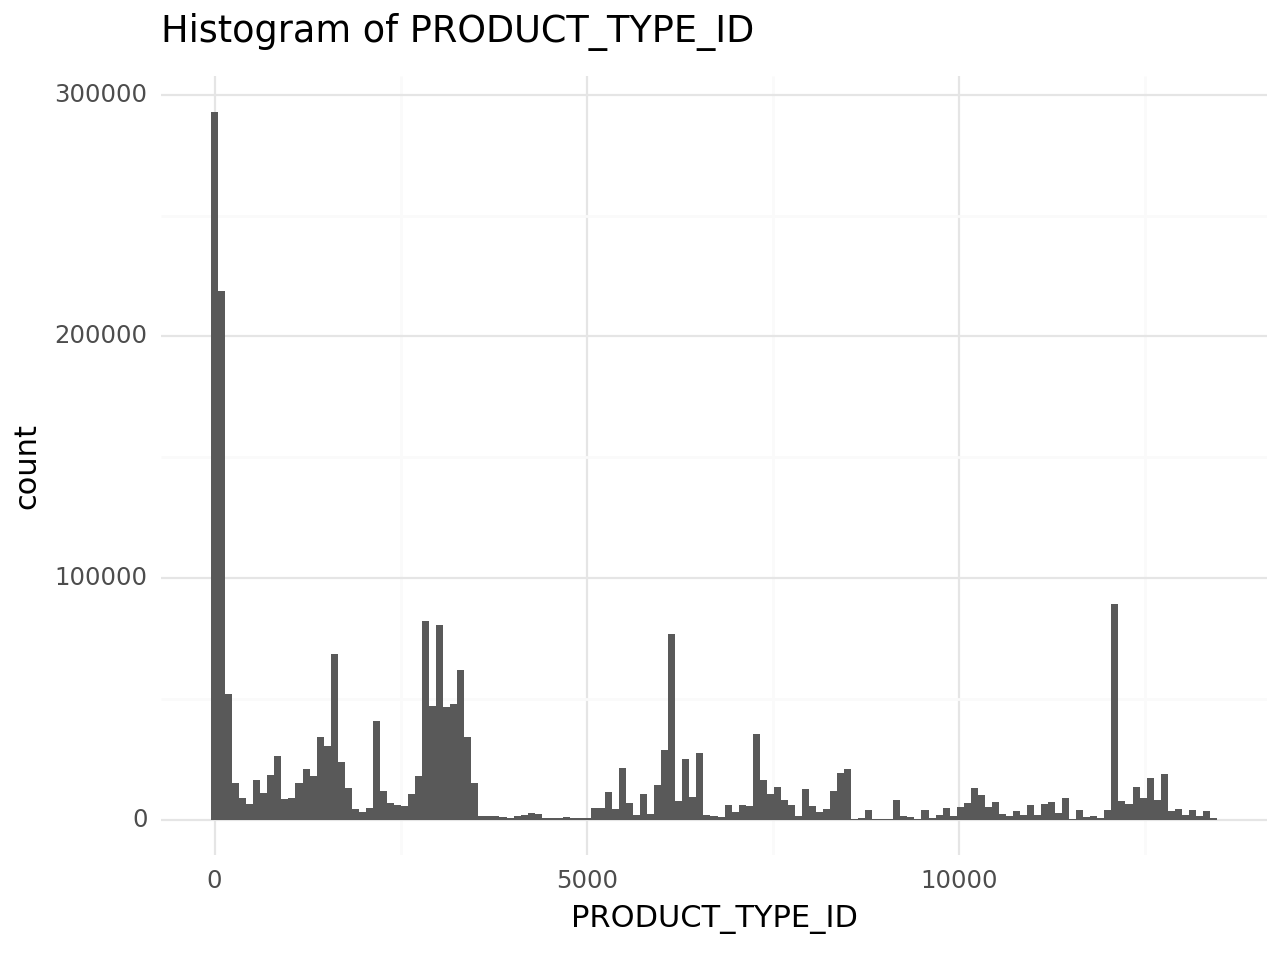

<Figure Size: (640 x 480)>

In [10]:
(ggplot(reviews, aes(x="PRODUCT_TYPE_ID"))
 + geom_histogram()
 + theme_minimal()
 + labs(title = "Histogram of PRODUCT_TYPE_ID"))

Although there are 12,907 unique `PRODUCT_TYPE_ID`s, the values range from 0-13420. A majority of items have low `PRODUCT_TYPE_ID`s (as evident with the tall lines for the lower values).


There are 12,907 unique products types in this Amazon dataset, compared to the 2,249,698 products in this dataset. 

Another potential project idea: use NLP to determine what connects all the products to a specific `PRODUCT_TYPE_ID`.

count    2.249698e+06
mean     4.071839e+03
std      1.351685e+06
min      1.000000e+00
25%      5.118110e+02
50%      6.630000e+02
75%      1.062992e+03
max      1.885801e+09
Name: PRODUCT_LENGTH, dtype: float64


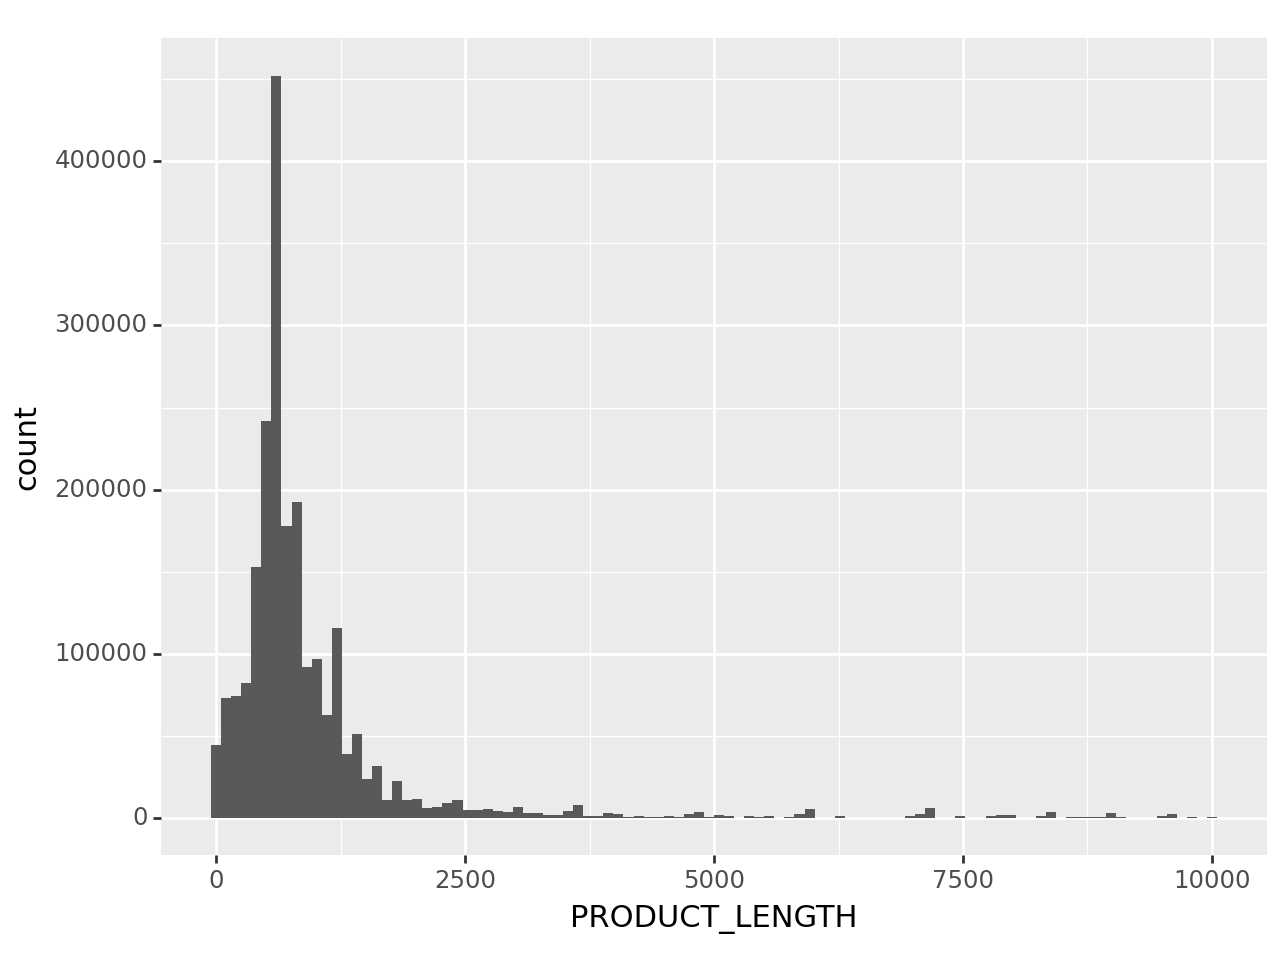

<Figure Size: (640 x 480)>

In [11]:
# Now, look at `PRODUCT_LENGTH`
print(reviews["PRODUCT_LENGTH"].describe())
(ggplot(reviews[reviews["PRODUCT_LENGTH"] <= 10000], aes(x="PRODUCT_LENGTH"))
 + geom_histogram(bins=100))

From the histogram above, we see that a majority of the `PRODUCT_LENGTH`s are between 100-1500, and the distribution is skewed right. There are a few outliers (many of which occur after 2500 or so). 

#### Rows

What information is provided for each product? What types of information are given?

In [12]:
for col in reviews.columns:
    print(f"{col}: {reviews[col][0]}")

PRODUCT_ID: 1925202
TITLE: ArtzFolio Tulip Flowers Blackout Curtain for Door, Window & Room | Eyelets & Tie Back | Canvas Fabric | Width 4.5feet (54inch) Height 5 feet (60 inch); Set of 2 PCS
BULLET_POINTS: [LUXURIOUS & APPEALING: Beautiful custom-made curtains to decorate any home or office | Includes inbuilt tieback to hold the curtain | Completely finished and ready to hang on walls & windows,MATERIAL: Luxurious & versatile fabric with a natural finish | High colour fastness | State-of-the-art digital printing ensures colour consistency and prevents any fading | Eyelets; Cotton Canvas; Width 4.5feet (54inch) | Multicolour | PACKAGE: 2 Room Curtains Eyelets | SIZE: Height 5 feet (60 inch); SET OF 2 PCS,BLACKOUT CURTAIN: 100% opaque & heavy premium cotton canvas fabric | Tight knitted, long life & durable fabric | Printing only on front side with a plain colour back side,MADE TO PERFECTION: Large eyelets at the top to put hanging hooks | Perfectly tailored seams for durability | Refin

In the row above, we see that `BULLET_POINTS` tends to give a description of the product itself. Unfortunately, the `DESCRIPTION` is not present.

In [13]:
for col in reviews.columns:
    print(f"{col}: {reviews[col][5]}")

PRODUCT_ID: 2152929
TITLE: HINS Metal Bucket Shape Plant Pot for Indoor & Outdoor Gardening (Red, Medium) Plant Stands for Indoor Balcony I Plant Bench I Plant Stands I Pot Stand Single I Potted Plant Stand I Big Pots I Metal
BULLET_POINTS: [Simple and elegant, great for displaying indoor plants like succulent plants, air plants, seedling, herbs etc.,High Quality - Both Indoor/outdoor planter stand and flower pots are made of wrought iron material, with powder coated paint, rustproof and durable.,Pefect decor for living room, balcony and garden.,BEST QUALITY, STRONG AND DURABLE - The surface of the pot holder is rust-proofed and it can be used for a longer time.,The elevated indoor potted plant stand can make watering easier and give the plant a better space to grow.,A pragmatic and eco-friendly gift for any nature lover, gardening hobbyist or home decorist.,Note : Plants are only for display.These are not included with Planter,Please allow 0~2cm errors due to manual measurement.]
DESC

In the product above, we see that the `BULLET_POINTS` and `DESCRIPTION` are both very similar in terms of the content that is presented.

## Data Cleaning

Instead of reinventing the wheel, we could use many of the preprocessing functions that Piyush Jain (the person who uploaded the dataset) created and used. This can be found at https://www.kaggle.com/code/piyushjain16/amazon-data-analysis#PreProcessing

In [14]:
# Preprocessing
# NOTE: All of the following functions are taken from Piyush. I do not claim to have written any of these.
def remove_url(txt):
    txt = re.sub(r"\w+:\/\/.*?(?=\s)", '', txt)
    return txt

def remove_email(text):
    return re.sub('\S*@\S*\s?', '', text)

# Function for expanding most common contractions
def decontraction(phrase):
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"&", "and", phrase)
    return phrase

def remove_escape_sequences(text):
    text=text.replace(r"\n","")
    text=text.replace(r"\t","")
    text=text.replace(r"\r","")
    return text

def remove_emojize(txt):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', txt) # no emoji

def remove_special(txt):
    # remove trademark and registered 
    pattern2=re.compile("\\u00AE|\\u00a9|\\u2122")
    txt=pattern2.sub(r'',txt)
    return txt

def remove_html(txt):
    pattern=re.compile('<.*?>')
    return pattern.sub(r'',txt)

def remove_phoneno(txt):
    pattern=re.compile("((?:\+\d{2}[-\.\s]??|\d{4}[-\.\s]??)?(?:\d{3}[-\.\s]??\d{3}[-\.\s]??\d{4}|\(\d{3}\)\s*\d{3}[-\.\s]??\d{4}|\d{3}[-\.\s]??\d{4}))")
    return pattern.sub(r'',txt)

def rename_units(txt):
    d={'in.':'inch','inches':'inch','yards':'yard','feets':'feet','centimeter':'cm','cms':'cm','metre':'m','mtr':'m','meters':'m'}
    for char in d.keys():
        txt = txt.replace(char, d[char])
    return txt

def replace_seq(txt):
    d={':-':':',': -':':',';':',','||':'|'}
    for char in d.keys():
        txt = txt.replace(char, d[char])
    return txt

def remove_other_langs(txt: str):
    """Own function - using `langdetect`, remove all texts where language is not detected to be 'en'

    Args:
        txt (str): text that language needs to be detected from
    """
    try:
        if type(txt) == str and detect(txt) != "en":
            txt = np.nan
    except LangDetectException:
        # When nothing is provided or words are not recognized
        txt = np.nan
    finally:
        return txt


def preprocessing(txt):
    if type(txt)==str:
        txt=remove_url(txt)
        txt=remove_email(txt)
        txt=remove_phoneno(txt)
        txt=remove_html(txt)
        txt=remove_emojize(txt)
        txt=remove_special(txt)
        txt=remove_escape_sequences(txt)
        txt=decontraction(txt)
        txt=txt.lower()
        txt=rename_units(txt)
        txt=replace_seq(txt)
        # txt=remove_other_langs(txt)
        return txt
    else:
        return np.nan

In [15]:
# Apply changes - again, taken from Piyush
reviews['TITLE'] = reviews['TITLE'].apply(preprocessing)
reviews['BULLET_POINTS'] = reviews['BULLET_POINTS'].apply(preprocessing)
reviews['DESCRIPTION'] = reviews['DESCRIPTION'].apply(preprocessing)

In [18]:
# View some of the changes
for i in range(20):
    print(reviews["TITLE"][i])
    print(reviews["BULLET_POINTS"][i])
    print(reviews["DESCRIPTION"][i])
    print("\n")


artzfolio tulip flowers blackout curtain for door, window and room | eyelets and tie back | canvas fabric | width 4.5feet (54inch) height 5 feet (60 inch), set of 2 pcs
[luxurious and appealing: beautiful custom-made curtains to decorate any home or office | includes inbuilt tieback to hold the curtain | completely finished and ready to hang on walls and windows,material: luxurious and versatile fabric with a natural finish | high colour fastness | state-of-the-art digital printing ensures colour consistency and prevents any fading | eyelets, cotton canvas, width 4.5feet (54inch) | multicolour | package: 2 room curtains eyelets | size: height 5 feet (60 inch), set of 2 pcs,blackout curtain: 100% opaque and heavy premium cotton canvas fabric | tight knitted, long life and durable fabric | printing only on front side with a plain colour back side,made to perfection: large eyelets at the top to put hanging hooks | perfectly tailored seams for durability | refined stitching with a matching

In [17]:
# Remove all products where `TITLE` is not present
rev_clean = reviews[reviews["TITLE"].notnull()]

# Finally, save the dataset
reviews[reviews["TITLE"].notnull()].to_csv(Path(os.getcwd()).parents[0].joinpath("data", "amazon_reviews_clean.csv"))